In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# IMPORT DATA
- **comments.csv** Contains raw patient comments.
- **apen.csv** Contains scores for attention to physical and environmental needs (0 = irrelevant, 1 = worst, 5 = best)


In [14]:
# Import data & merge comments and treatment scores
df_comments = pd.read_csv("comments.csv")
df_treatment = pd.read_csv("apen.csv")
df = pd.merge(df_comments, df_treatment, how="inner")

# 643 blank comments (those rows remove)
df = df.dropna(axis = 0)

# 9357 samples to work with
print(f'Number of rows {len(df)}')

df.head(5)

Number of rows 9357


,id,comment,apen
0,5876,I was told I wasnt allowed in with my house ma...,1.0
1,6555,Imagine telling a Rheumatoid Arthritis suffere...,0.0
2,1448,"Not exactly loved, but good to go when it's re...",4.0
3,3351,Shower facilities had a clear plastic bag of w...,0.0
4,231,Is worst place what I seen in my life. 8h wait...,0.0


In [15]:
# Very imbalanced dataset. Not many 1/2/3 (makes sense to map to binaries)
df["apen"].value_counts()

0.0    7425
5.0     973
4.0     431
1.0     314
2.0     199
3.0      15
Name: apen, dtype: int64

In [16]:
# Replace all values >0 with 0.
df["apen"].replace({1:1, 2:1, 3:1, 4:1, 5:1}, inplace=True)
df.head(5)

,id,comment,apen
0,5876,I was told I wasnt allowed in with my house ma...,1.0
1,6555,Imagine telling a Rheumatoid Arthritis suffere...,0.0
2,1448,"Not exactly loved, but good to go when it's re...",1.0
3,3351,Shower facilities had a clear plastic bag of w...,0.0
4,231,Is worst place what I seen in my life. 8h wait...,0.0


In [17]:
# Still imbalanced
class_weights = dict(df["apen"].value_counts())
class_weights

{0.0: 7425, 1.0: 1932}

# Preprocess Data

In [18]:
# Replace # and @ which are appear frequently at beginning of some words
df["comment"] = df["comment"].map(lambda x: x.replace("#", ""))
df["comment"] = df["comment"].map(lambda x: x.replace("@", ""))

# Focus on words, i.e. remove numbers and punctuation
def words_only(x):
    return " ".join(re.findall(r"[\w']+", x))
df["comment"] = df["comment"].apply(words_only)

In [19]:
# Tokenize text (punctuation removed by default, words moved to lower case, all words kept in this case)
sentences = list(df["comment"])
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True, split = ' ')
tokenizer.fit_on_texts(sentences)

vocab_size = len(tokenizer.word_counts)
print(f'vocab_size {vocab_size}')

word2idx = tokenizer.word_index
idx2word = {v:k for (k,v) in word2idx.items()}

vocab_size 16893


In [20]:
# To save computations I am going to truncate after 100 words (c. 90% + won't be affected)
seq_lengths = np.array([len(s.split()) for s in sentences])
print([(p, np.percentile(seq_lengths, p)) for p in [75, 80, 90, 95, 99, 100]])
max_seqlen = 100

[(75, 56.0), (80, 68.0), (90, 113.0), (95, 163.0), (99, 328.4400000000005), (100, 1384.0)]


# Prepare Dataset

In [22]:
# Vectorize sentences by turning words -> unique integers
sentences_as_ints = tokenizer.texts_to_sequences(sentences)
sentences_as_ints = tf.keras.preprocessing.sequence.pad_sequences(sentences_as_ints, maxlen=max_seqlen, padding='post')
label_as_ints = np.array(df["apen"])

print(f'Example sentence before: {sentences[5]}')
print(f'Example sentence after: {sentences_as_ints[5]}')

Example sentence before: Your whole walk in treatment process was faultless as was the treatment
Example sentence after: [ 101  269  431    8   64  382    6 1608   32    6    1   64    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [23]:
# Create a tensorflow dataset out of the data / labels (allows for transformations / iteration)
dataset = tf.data.Dataset.from_tensor_slices((sentences_as_ints, label_as_ints))

# Train / Test / Split

In [24]:
# Shuffle dataset, split into c. 80%, 10%, 10%.
dataset = dataset.shuffle(10000)
test_size = round(len(sentences)*0.10)
val_size = round(len(sentences)*0.10)
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)
print(f'train: {train_dataset.cardinality()}, val: {val_dataset.cardinality()}, test: {test_dataset.cardinality()}')

train: 7485, val: 936, test: 936


In [25]:
# Batch dataset for faster training
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Model Build / Training

In [26]:
# Bidrectional LSTM
class TreatmentClassifier(tf.keras.Model):
    def __init__(self, vocab_size, max_seqlen, **kwargs):
        super(TreatmentClassifier, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, max_seqlen)
        self.bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(max_seqlen))
        self.dense = tf.keras.layers.Dense(100, activation = 'relu')
        self.out = tf.keras.layers.Dense(1, activation = 'sigmoid')

    def call(self, x):
        x = self.embedding(x)
        x = self.bilstm(x)
        x = self.dense(x)
        x = self.out(x)
        return x

In [27]:
model = TreatmentClassifier(vocab_size+1, max_seqlen)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()

Model: "treatment_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1689400   
_________________________________________________________________
bidirectional (Bidirectional multiple                  160800    
_________________________________________________________________
dense (Dense)                multiple                  20100     
_________________________________________________________________
dense_1 (Dense)              multiple                  101       
Total params: 1,870,401
Trainable params: 1,870,401
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Save best model, set up call backs
data_dir = "./data"
logs_dir = os.path.join("./logs")
best_model_file = os.path.join(data_dir, "best_model_apen.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_file, save_weights_only=True, save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [30]:
# Number epochs = 10 (train on data 10 times), passing through 117 batches (of 64). Add class weights. Add callbacks.
num_epochs = 10
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset, class_weight = class_weights, callbacks=[checkpoint, tensorboard])

Epoch 1/10
  1/117 [..............................] - ETA: 0s - loss: 4654.0215 - accuracy: 0.6875WARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
117/117 [==============================] - 56s 474ms/step - loss: 1536.7275 - accuracy: 0.7977 - val_loss: 0.3964 - val_accuracy: 0.8237
Epoch 2/10
117/117 [==============================] - 56s 479ms/step - loss: 934.7787 - accuracy: 0.8728 - val_loss: 0.2793 - val_accuracy: 0.9038
Epoch 3/10
117/117 [==============================] - 64s 545ms/step - loss: 632.3220 - accuracy: 0.9204 - val_loss: 0.2712 - val_accuracy: 0.9145
Epoch 4/10
117/117 [==============================] - 60s 513ms/step - loss: 528.8871 - accuracy: 0.9337 - val_loss: 0.1548 - val_accuracy: 0.9530
Epoch 5/10
117/117 [======

# Model Analysis

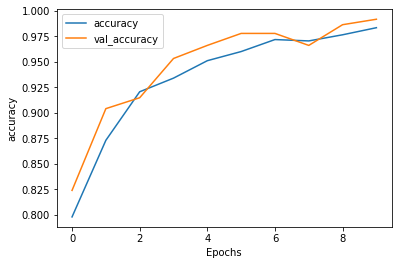

In [31]:
# Plot History and BCE loss. Nice training profile. High train and validation accuracy.
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["accuracy", "val_accuracy"])
plt.show()


In [32]:
# Download best model from each epoch (vs. validation data)
best_model = TreatmentClassifier(vocab_size+1, max_seqlen)
best_model.build(input_shape=(batch_size, max_seqlen))
best_model.load_weights(best_model_file)
best_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [33]:
# Test data performance....98.4% accuracy
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f'test accuracy: {test_acc}, test_loss: {test_loss}')

15/15 [==============================] - 1s 72ms/step - loss: 0.0339 - accuracy: 0.9904
test accuracy: 0.9903846383094788, test_loss: 0.03385428339242935


In [34]:
# Confusion Matrix. 
preds = []
labels = []
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = best_model.predict(inputs_b)
    preds.extend([1 if p > 0.5 else 0] for p in pred_batch)
    labels.extend([l.numpy() for l in labels_b])

false_pos = []
false_neg = []
for i in range(len(labels)):
    if preds[i] != labels[i]:
        if preds[i] == [1] and labels[i] == 0:
            false_pos.append(i)
        if preds[i] == [0] and labels[i] == 1:
            false_neg.append(i)

print(f'CONFUSION MATRIX')
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, preds)

CONFUSION MATRIX


array([[761,   1],
       [  7, 167]], dtype=int64)

In [35]:
# Look at false positives
false_pos_vectors = []
counter = 0
for x in test_dataset.unbatch():
    if counter in false_pos:
        inputs_b, labels_b = x
        false_pos_vectors.append(inputs_b)
    counter += 1

print(f'false positive indices: {false_pos}')

for vector in false_pos_vectors:
    print("-----")
    print(" ".join([idx2word[i] for i in list(vector.numpy()) if i !=0]))

false positive indices: [856]
-----
it was carried out in a professional way with kind people


In [36]:
# Look at false negatives
false_neg_vectors = []
counter = 0
for x in test_dataset.unbatch():
    if counter in false_neg:
        inputs_b, labels_b = x
        false_neg_vectors.append(inputs_b)
    counter += 1

print(f'false negative indices: {false_neg}')

for vector in false_neg_vectors:
    print("-----")
    print(" ".join([idx2word[i] for i in list(vector.numpy()) if i !=0]))

false negative indices: [40, 267, 316, 358, 479, 562, 798]
-----
the nurses are so friendly and professional help me relax and nothing is to much trouble
-----
hospital stay during covid was less than ideal but stgeorgestrust care was fantastic the free fast wifi made the stay so much easier free wifi especially important for patients at a time when no visitors are allowed the nhs outstandingcareeverytime
-----
the cleftteambch are so thoughtful bham childrens have always been amazing thank you https t co 7ocrw8rney
-----
waiting time
-----
me with an online safety magazine which triggered a mental breakdown i nearly killed myself several times due to the lack of therapy i've had over the past 4 years i simply had to just help myself get better seeing as no one from this hospital could be bothered to help me if anyone is thinking about going to this hospital or is being referred to this hospital i'm begging you don't go there consider my story consider the lives that were lost here due